## Code Modules & Helpful Functions

In [1]:
!pip install tensorflow_datasets

     |████████████████████████████████| 3.3 MB 4.8 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np,pylab as pl
import os,h5py,cv2,tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as th
from sklearn.model_selection import train_test_split
fpath='../input/flower-color-images/'
fw='weights.best.hdf5'

In [3]:
def prepro_resize_display(x_train,y_train,x_test,y_test,
                          n_classes,pixels):
    x_train=np.array(tf.image.resize(x_train,[pixels,pixels]))
    x_test=np.array(tf.image.resize(x_test,[pixels,pixels]))
    cy_train=np.array(tf.keras.utils\
    .to_categorical(y_train,n_classes),dtype='int32')
    cy_test=np.array(tf.keras.utils\
     .to_categorical(y_test,n_classes),dtype='int32')
    n=int(len(x_test)/2)
    x_valid,y_valid,cy_valid=x_test[:n],y_test[:n],cy_test[:n]
    x_test,y_test,cy_test=x_test[n:],y_test[n:],cy_test[n:]
    df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                     [x_train.dtype,x_valid.dtype,x_test.dtype],
                     [y_train.shape,y_valid.shape,y_test.shape],
                     [y_train.dtype,y_valid.dtype,y_test.dtype],
                     [cy_train.shape,cy_valid.shape,cy_test.shape],
                     [cy_train.dtype,cy_valid.dtype,cy_test.dtype]],
                    columns=['train','valid','test'],
                    index=['image shape','image type',
                           'label shape','label type',
                           'shape of encoded label','type of encoded label'])
    display(df)    
    return [[x_train,x_valid,x_test],
            [y_train,y_valid,y_test],
            [cy_train,cy_valid,cy_test]]

## Data
From external sources

In [4]:
ds=tfds.load('tf_flowers',split='train',
             shuffle_files=True,as_supervised=True)



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


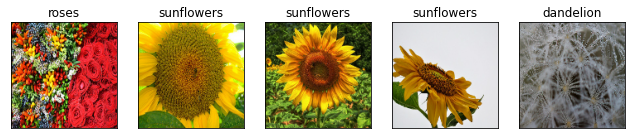

In [5]:
s=128; n=3670; i=0
x=np.zeros((n,s,s,3),dtype='float32')
y=np.zeros((n,1),dtype='int32')
for f,t in ds.take(n):
    f=tf.image.resize(f,[s,s])
    x[i,:]=f/255
    y[i,:]=t; i+=1
x_train1,x_test1,y_train1,y_test1=\
train_test_split(x,y,test_size=.1,random_state=1)
names1=['dandelion','daisy','tulips','sunflowers','roses']
fig=pl.figure(figsize=(11,4))    
for i in range(5):
    ax=fig.add_subplot(1,5,i+1,\
    xticks=[],yticks=[],title=names1[y_train1[i][0]])
    ax.imshow((x_train1[i]))

In [6]:
with h5py.File('TfFlowerImages.h5','w') as f:
    f.create_dataset('train_images',data=x_train1)
    f.create_dataset('train_labels',data=y_train1)
    f.create_dataset('test_images',data=x_test1)
    f.create_dataset('test_labels',data=y_test1)
os.stat('TfFlowerImages.h5')

os.stat_result(st_mode=33188, st_ino=131083, st_dev=1793, st_nlink=1, st_uid=0, st_gid=0, st_size=721570136, st_atime=1590695505, st_mtime=1590695506, st_ctime=1590695506)

In [7]:
[[x_train1,x_valid1,x_test1],
 [y_train1,y_valid1,y_test1],
 [cy_train1,cy_valid1,cy_test1]]=\
prepro_resize_display(x_train1,y_train1,x_test1,y_test1,5,160)

,train,valid,test
image shape,"(3303, 160, 160, 3)","(183, 160, 160, 3)","(184, 160, 160, 3)"
image type,float32,float32,float32
label shape,"(3303, 1)","(183, 1)","(184, 1)"
label type,int32,int32,int32
shape of encoded label,"(3303, 5)","(183, 5)","(184, 5)"
type of encoded label,int32,int32,int32


From internal sources

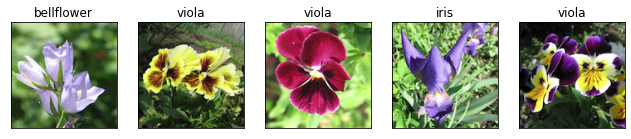

In [8]:
f=h5py.File(fpath+'FlowerColorImages.h5','r')
keys=list(f.keys())
images=np.array(f[keys[0]],dtype='float32')/255
labels=np.array(f[keys[1]],dtype='int32').reshape(-1,1)
x_train2,x_test2,y_train2,y_test2=\
train_test_split(images,labels,test_size=.1,random_state=1)
names2=['phlox','rose','calendula','iris',
        'max chrysanthemum','bellflower','viola',
        'rudbeckia laciniata','peony','aquilegia']
fig=pl.figure(figsize=(11,4))
n=np.random.randint(1,30)
for i in range(n,n+5):
    ax=fig.add_subplot(1,5,i-n+1,xticks=[],yticks=[],\
    title=names2[int(labels[i])])
    ax.imshow((images[i]))

In [9]:
[[x_train2,x_valid2,x_test2],
 [y_train2,y_valid2,y_test2],
 [cy_train2,cy_valid2,cy_test2]]=\
prepro_resize_display(x_train2,y_train2,x_test2,y_test2,10,160)

,train,valid,test
image shape,"(189, 160, 160, 3)","(10, 160, 160, 3)","(11, 160, 160, 3)"
image type,float32,float32,float32
label shape,"(189, 1)","(10, 1)","(11, 1)"
label type,int32,int32,int32
shape of encoded label,"(189, 10)","(10, 10)","(11, 10)"
type of encoded label,int32,int32,int32


## NN Examples

In [10]:
def premodel(pix,den,mh,lbl):
    model=tf.keras.Sequential([
        tf.keras.layers.Input((pix,pix,3),
                              name='input'),
        th.KerasLayer(mh,trainable=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(den,activation='relu'),
        tf.keras.layers.Dropout(rate=.5),
        tf.keras.layers.Dense(lbl,activation='softmax')])
    model.compile(optimizer='adam',metrics=['accuracy'],
                  loss='sparse_categorical_crossentropy')
    display(model.summary())
    return model
def cb(fw):
    early_stopping=tf.keras.callbacks\
    .EarlyStopping(monitor='val_loss',patience=20,verbose=2)
    checkpointer=tf.keras.callbacks\
    .ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
    lr_reduction=tf.keras.callbacks\
    .ReduceLROnPlateau(monitor='val_loss',verbose=2,
                       patience=5,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

In [11]:
[handle_base,pixels]=["mobilenet_v1_050_160",160]
mhandle="https://tfhub.dev/google/imagenet/{}/feature_vector/4"\
.format(handle_base)

In [12]:
model=premodel(pixels,1024,mhandle,5)
history=model.fit(x=x_train1,y=y_train1,batch_size=128,
                  epochs=25,callbacks=cb(fw),
                  validation_data=(x_valid1,y_valid1))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               829536    
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 1,359,973
Trainable params: 1,349,029
Non-trainable params: 10,944
_________________________________________________________________


None

Train on 3303 samples, validate on 183 samples
Epoch 1/25
3200/3303 [============================>.] - ETA: 2s - loss: 0.8028 - accuracy: 0.7634
Epoch 00001: val_loss improved from inf to 1.45388, saving model to weights.best.hdf5
3303/3303 [==============================] - 79s 24ms/sample - loss: 0.7888 - accuracy: 0.7681 - val_loss: 1.4539 - val_accuracy: 0.7158
Epoch 2/25
3200/3303 [============================>.] - ETA: 2s - loss: 0.2612 - accuracy: 0.9394
Epoch 00002: val_loss improved from 1.45388 to 0.73388, saving model to weights.best.hdf5
3303/3303 [==============================] - 74s 22ms/sample - loss: 0.2588 - accuracy: 0.9404 - val_loss: 0.7339 - val_accuracy: 0.8251
Epoch 3/25
3200/3303 [============================>.] - ETA: 2s - loss: 0.1608 - accuracy: 0.9737
Epoch 00003: val_loss did not improve from 0.73388
3303/3303 [==============================] - 72s 22ms/sample - loss: 0.1593 - accuracy: 0.9746 - val_loss: 1.3882 - val_accuracy: 0.7486
Epoch 4/25
3200/3303 

In [13]:
model.load_weights(fw)
model.evaluate(x_test1,y_test1)

184/184 [==============================] - 1s 4ms/sample - loss: 0.5763 - accuracy: 0.8750


[0.5763072228950002, 0.875]

In [14]:
[handle_base,pixels]=["mobilenet_v2_100_160",160]
mhandle="https://tfhub.dev/google/imagenet/{}/feature_vector/4"\
.format(handle_base)

In [15]:
model=premodel(pixels,512,mhandle,10)
history=model.fit(x=x_train2,y=y_train2,batch_size=64,
                  epochs=10,callbacks=cb(fw),
                  validation_data=(x_valid2,y_valid2))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 2,918,986
Trainable params: 2,884,874
Non-trainable params: 34,112
_________________________________________________________________


None

Train on 189 samples, validate on 10 samples
Epoch 1/10
128/189 [===================>..........] - ETA: 6s - loss: 2.4330 - accuracy: 0.2578 
Epoch 00001: val_loss improved from inf to 1.75185, saving model to weights.best.hdf5
189/189 [==============================] - 18s 94ms/sample - loss: 2.2388 - accuracy: 0.2857 - val_loss: 1.7518 - val_accuracy: 0.5000
Epoch 2/10
128/189 [===================>..........] - ETA: 3s - loss: 0.6250 - accuracy: 0.8516
Epoch 00002: val_loss did not improve from 1.75185
189/189 [==============================] - 10s 55ms/sample - loss: 0.5521 - accuracy: 0.8730 - val_loss: 2.2611 - val_accuracy: 0.4000
Epoch 3/10
128/189 [===================>..........] - ETA: 3s - loss: 0.2238 - accuracy: 0.9688
Epoch 00003: val_loss did not improve from 1.75185
189/189 [==============================] - 10s 56ms/sample - loss: 0.2130 - accuracy: 0.9735 - val_loss: 2.9097 - val_accuracy: 0.4000
Epoch 4/10
128/189 [===================>..........] - ETA: 3s - loss: 0.1

In [16]:
model.load_weights(fw)
model.evaluate(x_test2,y_test2)

11/11 [==============================] - 0s 9ms/sample - loss: 2.5775 - accuracy: 0.2727


[2.5775489807128906, 0.27272728]